## Inteligência de Dados: Mapeamento e Análises Relacionais

### Cenário

O projeto visa desenvolver um banco de dados relacional para o Departamento de Inteligência de Dados (ID) de um banco fictício, utilizando um modelo que incorpora três tabelas principais: dados_origem, fluxo_dados e analises. Este modelo é projetado para suportar todo o processo de extração, carregamento, transformação e análise de dados, permitindo que a equipe de dados gerencie e analise informações de maneira eficiente. Utilizarei PostgreSQL como sistema de gerenciamento de banco de dados, o que traz vantagens como suporte a transações complexas, escalabilidade superior e robustez no gerenciamento de dados. Além disso, a biblioteca Pandas facilitará a manipulação e análise dos dados, complementando as capacidades do PostgreSQL.

Para preencher as tabelas com dados fictícios, será empregada a biblioteca Faker, que criará informações realistas de maneira aleatória, assegurando a integridade dos testes e simulações. Os comandos mágicos do IPython-SQL serão utilizados no Jupyter Notebook para simplificar a interação com o banco de dados e a execução de consultas SQL. Além disso, a visualização do modelo de entidade-relacionamento (ER) será realizada por meio da biblioteca Graphviz, possibilitando uma representação clara e intuitiva das relações entre as tabelas e seus respectivos fluxos de dados.

### Estrutura do Banco de Dados (*smart_data_db*)

#### 1. Tabela: dados_origem
Esta tabela armazena informações sobre as diferentes fontes de dados que estão sendo utilizadas.

| Coluna           | Tipo           | Descrição                                       |
|------------------|----------------|-------------------------------------------------|
| id_origem        | SERIAL (PK)    | Identificador único da origem dos dados         |
| nome_origem      | VARCHAR(255)   | Nome da origem dos dados                        |
| tipo_dado        | VARCHAR(100)   | Tipo de dado (ex: transacional, log, etc.)      |
| volume           | INT            | Volume estimado de dados na origem              |
| latencia         | VARCHAR(50)    | Latência de atualização (ex: real-time, diário) |
| descricao        | TEXT           | Descrição detalhada da origem                   |


#### 2. Tabela: fluxo_dados
Esta tabela representa os fluxos de dados desde a origem até o consumo final.

| Coluna           | Tipo           | Descrição                                       |
|------------------|----------------|-------------------------------------------------|
| id_fluxo         | SERIAL (PK)    | Identificador único do fluxo de dados           |
| id_origem        | INT (FK)       | Referência para a origem dos dados              |
| destino          | VARCHAR(255)   | Destino do fluxo (ex: analistas, sistemas)      |
| status           | VARCHAR(50)    | Status do fluxo (ex: ativo, inativo)            |
| data_criacao     | TIMESTAMP      | Data em que o fluxo foi criado                  |
| data_atualizacao | TIMESTAMP      | Data da última atualização do fluxo             |

#### 3. Tabela: analises
Esta tabela armazena as análises realizadas com os dados, incluindo suas hipóteses e resultados.

| Coluna           | Tipo           | Descrição                                       |
|------------------|----------------|-------------------------------------------------|
| id_analise       | SERIAL (PK)    | Identificador único da análise                  |
| id_fluxo         | INT (FK)       | Referência para o fluxo de dados utilizado      |
| hipoteses        | TEXT           | Hipóteses levantadas para a análise             |
| resultado        | TEXT           | Resultados da análise                           |
| data_analise     | TIMESTAMP      | Data em que a análise foi realizada             |
| responsavel      | VARCHAR(255)   | Nome do responsável pela análise                |

### Bibliotecas utilizadas

In [1]:
import os
import warnings
from datetime import datetime

import pandas as pd
from dotenv import load_dotenv
import psycopg2
from graphviz import Digraph
from IPython.display import Image, display

from generate_random_data import DbConfig, DataGenerator
from postgres_setup import PostgresConnector


In [2]:
warnings.filterwarnings('ignore')

### Diagrama ER

In [3]:
def diagrama_er():
    dot = Digraph(comment='Diagrama ER do Banco de Dados')
    dot.attr(rankdir='LR')  # Orientação da esquerda para direita
    
    dot.node('DadosOrigem', '''dados_origem
    ----
    + id_origem (PK)
    nome_origem
    tipo_dado
    volume
    latencia
    descricao''')
    
    dot.node('FluxoDados', '''fluxo_dados
    ----
    + id_fluxo (PK)
    # id_origem (FK)
    destino
    status
    data_criacao
    data_atualizacao''')
    
    dot.node('Analises', '''analises
    ----
    + id_analise (PK)
    # id_fluxo (FK)
    hipoteses
    resultado
    data_analise
    responsavel''')
    
    # Adiciona relacionamentos
    dot.edge('DadosOrigem', 'FluxoDados', '1:N')
    dot.edge('FluxoDados', 'Analises', '1:N')
    
    return dot

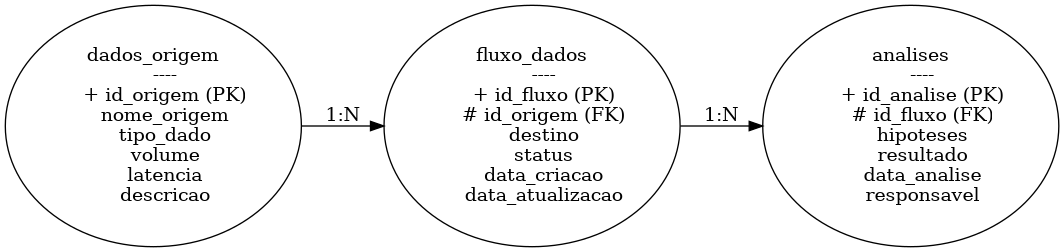

In [4]:
diagrama = diagrama_er()
diagrama.render('diagrama_er', format='png', cleanup=True)
display(Image(filename='diagrama_er.png'))

### Conexão e configuração do banco

In [5]:
load_dotenv()

True

In [6]:
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")

In [7]:
db_params = {
    'dbname': 'smart_data_db',
    'user': db_user,
    'password': db_password,
    'host': 'localhost',
    'port': '5432'
}

In [8]:
postgres = PostgresConnector(**db_params)

In [9]:
postgres.create_database_tables()

In [10]:
config = DbConfig(**db_params)

In [11]:
with DataGenerator(config) as generator:
    df_origem, df_fluxo, df_analises = generator.gerar_e_inserir_dados()

In [12]:
df_origem.head(3)

,id_origem,nome_origem,tipo_dado,volume,latencia,descricao
0,1,Sistema App Mobile - Alves e Filhos,sensor,1865366,diário,Dolore qui perspiciatis tempora assumenda. Adi...
1,2,Sistema App Mobile - Pires,log,6818101,mensal,Neque provident aliquid dolorem enim aspernatu...
2,3,Sistema Plataforma de Streaming - Câmara,documento,3758117,batch,Laudantium quidem similique corrupti cum persp...


In [13]:
df_fluxo.head(3)

,id_fluxo,id_origem,destino,status,data_criacao,data_atualizacao
0,1,71,Data Warehouse,ativo,2023-01-13 14:05:00,2023-02-07 16:44:00
1,2,36,API Gateway,em teste,2023-01-21 15:07:00,2023-02-07 10:07:00
2,3,1,API Gateway,em manutenção,2023-01-18 01:48:00,2023-02-04 08:43:00


In [14]:
df_analises.head(3)

,id_analise,id_fluxo,hipoteses,resultado,data_analise,responsavel
0,1,13,Hipótese: Análise de Comportamento de Transaçõ...,Dicta quasi atque. Labore placeat est eum occa...,2023-02-18 05:37:00,Ryan Santos
1,2,157,Hipótese: Análise de Comportamento de Transaçõ...,Sint nisi similique cum minus. Eos ea facilis ...,2023-02-03 22:03:00,Samuel Barros
2,3,115,Hipótese: Segmentação de Clientes - Reiciendis...,Minus quasi rerum aspernatur dolor. Atque quam...,2023-03-02 04:49:00,Arthur Gabriel da Paz


### Padrões dos dados

#### Interpretação, avaliação, investigação e resultados. 